<a href="https://colab.research.google.com/github/mirchandani-mohnish/ClusterMetrics/blob/main/Density_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from sklearn import datasets
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
import heapq
from scipy.spatial.distance import euclidean
from sklearn.cluster import DBSCAN


In [9]:
seed = 0

In [10]:
def k_means(X, k, max_iter=300, tol=1e-4):

    # Step 1: Initialize centroids randomly from the dataset
    n_samples, n_features = X.shape
    rng = np.random.default_rng(seed)
    centroids = X[rng.choice(n_samples, k, replace=False)]

    for _ in range(max_iter):
        # Step 2: Assign each data point to the nearest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)

        # Step 3: Compute new centroids
        new_centroids = np.array([X[cluster_assignments == j].mean(axis=0) if np.any(cluster_assignments == j) else centroids[j]
                                  for j in range(k)])

        # Step 4: Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return cluster_assignments, centroids


In [47]:
import pdb
import sys

def dbscan_base(df, eps, MinPts):
    # Extract the features (excluding the target)
    # D = df.drop(['target', 'species', 'dbscan_predictions'], axis=1).values
    D = df
    # Mark all points as unvisited
    n = len(D)
    visited = [False] * n
    clusters = []
    noise = []



    for i in range(n):
        if not visited[i]:
            visited[i] = True
            neighbors = region_query(D, i, eps)

            if len(neighbors) < MinPts:
                noise.append(i)
            else:
                cluster = []
                expand_cluster(D, i, neighbors, cluster, eps, MinPts, visited)
                clusters.append(cluster)
    print(clusters)

    cluster_labels = generate_cluster_labels(D, clusters, noise)

    return clusters, noise, cluster_labels

def expand_cluster(D, P, neighbors, cluster, eps, MinPts, visited):
    cluster.append(P)
    i = 0
    while i < len(neighbors):
        Q = neighbors[i]
        if not visited[Q]:
            visited[Q] = True
            Q_neighbors = region_query(D, Q, eps)
            if len(Q_neighbors) >= MinPts:
                neighbors += Q_neighbors
        if Q not in cluster:
            cluster.append(Q)
        i += 1

def region_query(D, P, eps):
    neighbors = []
    for i in range(len(D)):
        if euclidean(D[P], D[i]) < eps:
            neighbors.append(i)
    return neighbors

def generate_cluster_labels(D, clusters, noise):
    cluster_labels = np.full(len(D), -1)
    print(len(cluster_labels))
    for i in range(0,len(clusters)):
        for x in clusters[i]:
            cluster_labels[x] = i

    for x in noise:
        cluster_labels[x] = -1

    return cluster_labels

    # for i in range(len(clusters)):
    #     for j in range(len(clusters[i])):
    #         D.loc[clusters[i][j], 'custom_dbscan_predictions'] = int(i)
    # for i in range(len(noise)):
    #     D.loc[noise[i], 'custom_dbscan_predictions'] = -1



In [48]:
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()

print("Iris Dataset\n")

start_time = time.time()
# labels_base_iris, centroids_base_iris = k_means(X_iris, k_iris)
cluters, noise, labels_base_iris = dbscan_base(X_iris, 0.3, 5)
print(labels_base_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"Silhouette score (base): {silhouette_score(X_iris, labels_base_iris)}")

start_time = time.time()
# kmeans_iris = KMeans(n_clusters=k_iris, random_state=seed).fit(X_iris)
dbscan_iris = DBSCAN().fit(X_iris)

labels_sklearn_iris = dbscan_iris.labels_
print(labels_sklearn_iris)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"Silhouette score (sklearn): {silhouette_score(X_iris, labels_sklearn_iris)}")

Iris Dataset

[[0, 4, 7, 17, 27, 28, 39, 40, 49, 19, 21, 46, 11, 26, 10, 48, 9, 34, 35, 37, 24, 29, 30, 23, 43, 1, 12, 25, 45, 3, 47, 2, 8, 38, 42, 6, 13], [69, 80, 81, 89, 92, 67, 82, 99, 88, 94, 95, 96], [127, 70, 126, 138, 149]]
150
[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1 -1 -1  0 -1  0 -1  0 -1  0
  0  0  0  0  0  0  0 -1 -1 -1  0  0 -1  0  0  0  0 -1  0  0 -1  0  0  0
  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1  1 -1  1  1
  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  2]
Execution time (base): 0.4385230541229248 seconds
Silhouette score (base): -0.08136950360698288
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1 -1 

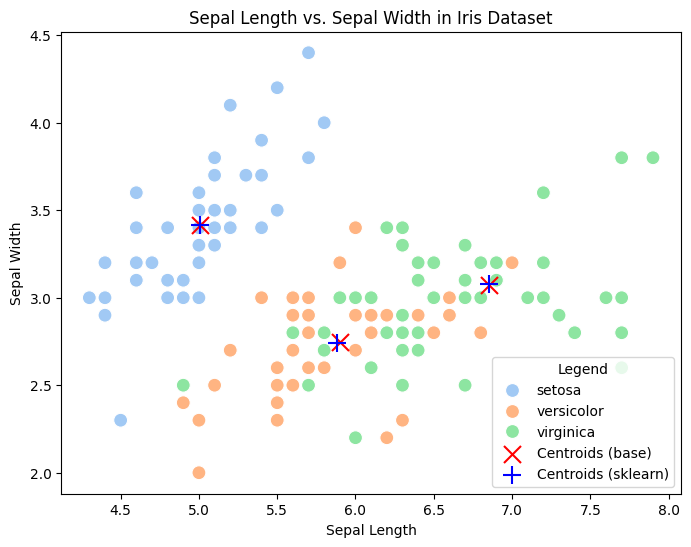

In [ ]:
# centroids_base_iris = scaler_iris.inverse_transform(centroids_base_iris)
# centroids_sklearn_iris = scaler_iris.inverse_transform(centroids_sklearn_iris)

slength_idx = list(iris_filtered.columns).index("sepal_length")
swidth_idx = list(iris_filtered.columns).index("sepal_width")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="pastel", s=100)
plt.scatter(centroids_base_iris[:, slength_idx], centroids_base_iris[:, swidth_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_iris[:, slength_idx], centroids_sklearn_iris[:, swidth_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Sepal Length vs. Sepal Width in Iris Dataset")
plt.legend(title="Legend")
plt.show()

In [ ]:
path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score"])

ai_filtered = ai.select_dtypes(include=['float64'])

# scaler_ai = StandardScaler()
X_ai = ai_filtered.to_numpy()
k_ai = 3

print("AI Global Index")

start_time = time.time()
labels_base_ai, centroids_base_ai = k_means(X_ai, k_ai)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"Silhouette score (base): {silhouette_score(X_ai, labels_base_ai)}")

start_time = time.time()
kmeans_ai = KMeans(n_clusters=k_ai, random_state=seed).fit(X_ai)
labels_sklearn_ai = kmeans_ai.labels_
centroids_sklearn_ai = kmeans_ai.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"Silhouette score (sklearn): {silhouette_score(X_ai, labels_sklearn_ai)}")

AI Global Index
Execution time (base): 0.0016078948974609375 seconds
Silhouette score (base): 0.2645619495141555

Execution time (sklearn): 0.0023336410522460938 seconds
Silhouette score (sklearn): 0.2645619495141555


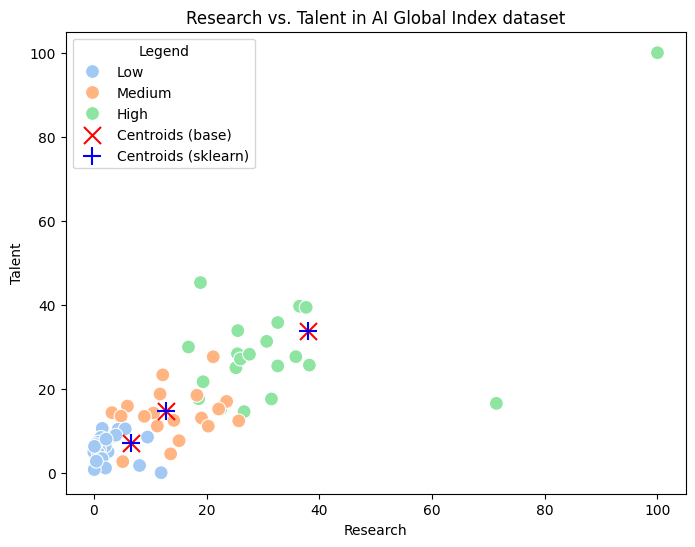

In [ ]:
# centroids_base_ai = scaler_ai.inverse_transform(centroids_base_ai)
# centroids_sklearn_ai = scaler_ai.inverse_transform(centroids_sklearn_ai)

research_idx = list(ai_filtered.columns).index("Research")
talent_idx = list(ai_filtered.columns).index("Talent")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="pastel", s=100)
plt.scatter(centroids_base_ai[:, research_idx], centroids_base_ai[:, talent_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_ai[:, research_idx], centroids_sklearn_ai[:, talent_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("Research")
plt.ylabel("Talent")
plt.title("Research vs. Talent in AI Global Index dataset")
plt.legend(title="Legend")
plt.show()

In [ ]:
path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["time", "updated", "timezone", "latitude", "longitude", "tsunami", "nst", "dmin", "gap", "distanceKM", "postcode"])
earthquakes_filtered = earthquakes.select_dtypes(include=['float64', 'int64'])

X_earth = earthquakes_filtered.to_numpy()
k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
labels_base_earth, centroids_base_earth = k_means(X_earth, k_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print(f"Silhouette score (base): {silhouette_score(X_earth, labels_base_earth)}")

start_time = time.time()
kmeans_earth = KMeans(n_clusters=k_earth, random_state=seed).fit(X_earth)
labels_sklearn_earth = kmeans_earth.labels_
centroids_sklearn_earth = kmeans_earth.cluster_centers_
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print(f"Silhouette score (sklearn): {silhouette_score(X_earth, labels_sklearn_earth)}")

Global Earthquake Data
Execution time (base): 0.009125471115112305 seconds
Silhouette score (base): 0.9394003844844655

Execution time (sklearn): 0.0044138431549072266 seconds
Silhouette score (sklearn): 0.9568851143031006


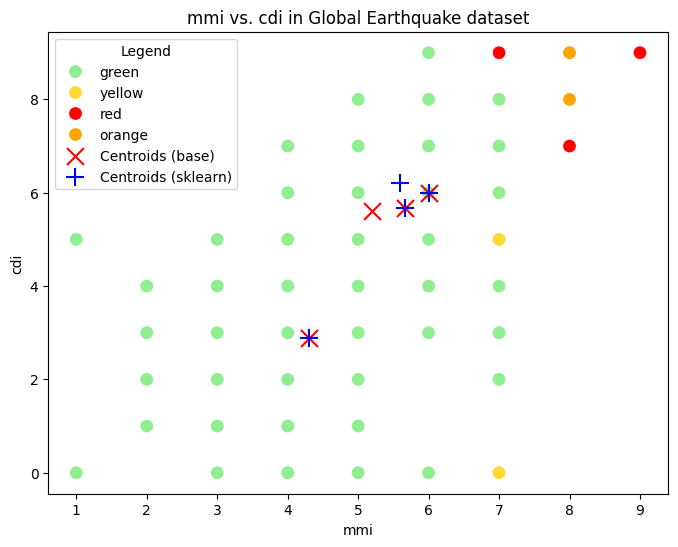

In [ ]:
cdi_idx = list(earthquakes_filtered.columns).index("cdi")
mmi_idx = list(earthquakes_filtered.columns).index("mmi")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette={"green": "lightgreen", "orange": "orange", "red": "red", "yellow": sns.color_palette("Set2")[-3]}, s=100)
plt.scatter(centroids_base_earth[:, mmi_idx], centroids_base_earth[:, cdi_idx], c='red', marker='x', s=150, label='Centroids (base)')
plt.scatter(centroids_sklearn_earth[:, mmi_idx], centroids_sklearn_earth[:, cdi_idx], c='blue', marker='+', s=150, label='Centroids (sklearn)')

plt.xlabel("mmi")
plt.ylabel("cdi")
plt.title("mmi vs. cdi in Global Earthquake dataset")
plt.legend(title="Legend")
plt.show()